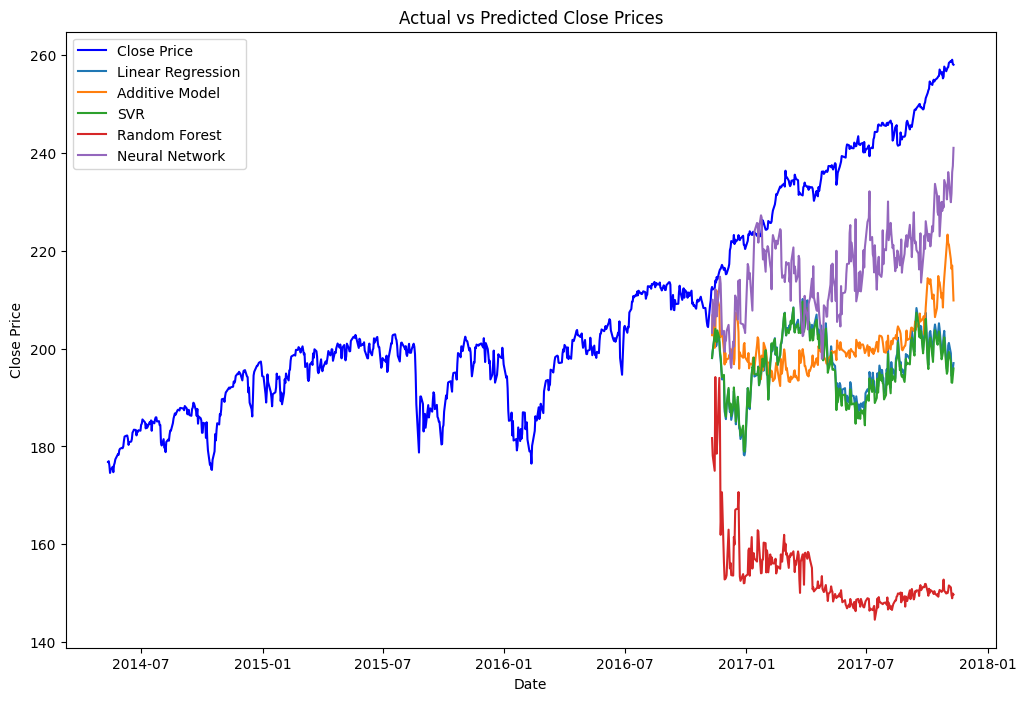

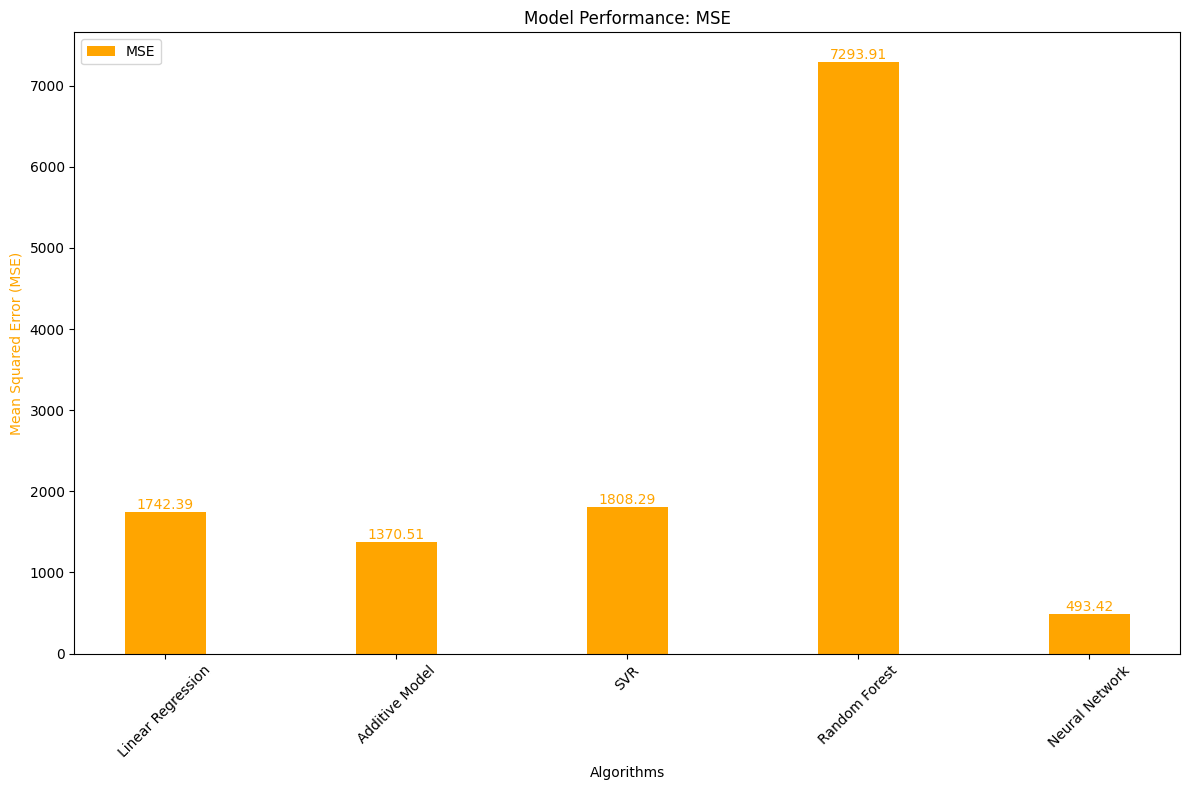

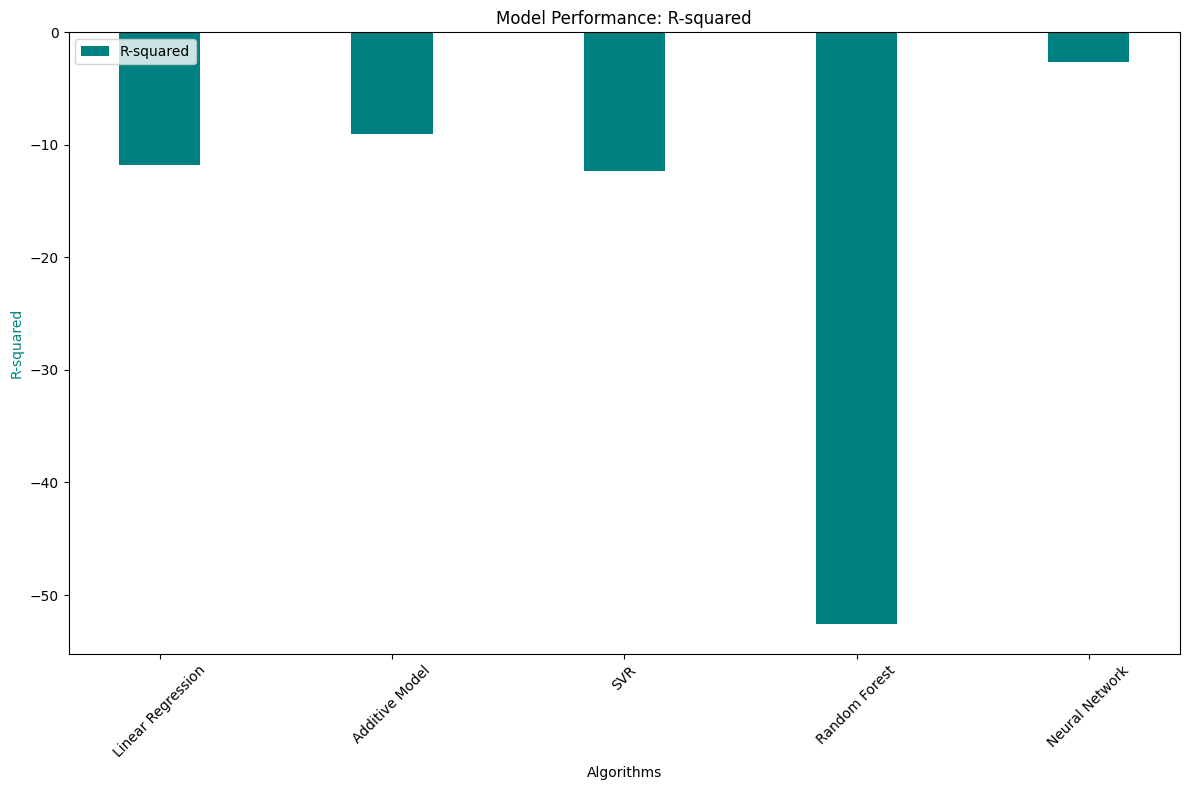

In [1]:
# basica modeller, uten leakage, med close og volume lagged

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pygam import LinearGAM, s
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cross_decomposition import PLSRegression
from sklearn.feature_selection import RFE

def create_date_features(df):
    """Create cyclical date features."""
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    # Sine-cosine encoding for cyclical features
    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    """Add lagged features starting from min_lag to max_lag using optimized approach."""
    lagged_features = []  # List to store all lagged feature DataFrames
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            # Create a temporary DataFrame for the lagged feature
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    return df

# Load the data
df = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt')

# Convert Date column to datetime and set it as the index
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Feature engineering: Create date-related, rolling, and lagged features
df = create_date_features(df)
# df = create_rolling_features(df, window_sizes=[10])
df = create_lagged_features(df, min_lag=20 * 16, max_lag=20 * 60)

# Drop irrelevant columns
df = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'DayOfYear', 'WeekOfYear', 'Month'])

# Drop rows with NaN values (created by lagged and rolling features)
df.dropna(inplace=True)

# Define the target variable and features
y = df['Close']
features = [col for col in df.columns if col != 'Close']
X = df[features]

# Split the data into training and testing sets
end_date = df.index.max()
start_date = end_date - pd.DateOffset(years=1)

train_X = X[X.index < start_date]
train_y = y[X.index < start_date]
test_X = X[X.index >= start_date]
test_y = y[X.index >= start_date]

# Normalize features
scaler = MinMaxScaler()
train_X_normalized = scaler.fit_transform(train_X)
test_X_normalized = scaler.transform(test_X)

# PLS dimensionality reduction
pls = PLSRegression(n_components=train_X_normalized.shape[1])  # Start with max components
pls.fit(train_X_normalized, train_y)
cumulative_variance = np.cumsum(np.sum(pls.x_scores_**2, axis=0) / np.sum(pls.x_scores_**2))
n_components = np.argmax(cumulative_variance >= 0.95) + 1  # Number of components for 95% variance

pls = PLSRegression(n_components=n_components)
train_X_pls = pls.fit_transform(train_X_normalized, train_y)[0]
test_X_pls = pls.transform(test_X_normalized)

# RFE feature selection
rfe = RFE(estimator=LinearRegression(), n_features_to_select=0.95)
train_X_rfe = rfe.fit_transform(train_X_pls, train_y)
test_X_rfe = rfe.transform(test_X_pls)

# Initialize models
models = {
    'Linear Regression': LinearRegression(),
    'Additive Model': LinearGAM(s(0, n_splines=20, lam=0.1) + s(1, n_splines=20, lam=0.1) + 
                s(2, n_splines=20, lam=0.1) + s(3, n_splines=20, lam=0.1) + 
                s(4, n_splines=20, lam=0.1)),
    'SVR': SVR(kernel='linear', C=100, epsilon=5),
    'Random Forest': RandomForestRegressor(
        n_estimators=1000,
        max_depth=15,
        max_features='sqrt',
        min_samples_split=10,
        min_samples_leaf=5,
        bootstrap=True,
        random_state=42,
    ),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(50, 50), max_iter=2000, learning_rate_init=0.001, alpha=0.01),
}

# Train models and generate predictions
# Train models and generate predictions
predictions = {}
mse_values = {}
r2_values = {}

for name, model in models.items():
    model.fit(train_X_rfe, train_y)
    pred = model.predict(test_X_rfe)
    predictions[name] = pred
    mse_values[name] = mean_squared_error(test_y, pred)
    r2_values[name] = model.score(test_X_rfe, test_y)  # Calculate R-squared

# Add actual values for comparison
pred_df = pd.DataFrame(predictions, index=test_X.index)
pred_df['Actual'] = test_y

# Plot actual vs. predicted prices
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')

# Plot each model's predictions
for name, pred in predictions.items():
    plt.plot(test_y.index, pred, label=name)

plt.title("Actual vs Predicted Close Prices")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()



# Plot MSE values
plt.figure(figsize=(12, 8))
x = np.arange(len(mse_values))
bar_width = 0.35

# Plot MSE bars
mse_bars = plt.bar(x, list(mse_values.values()), bar_width, label='MSE', color='orange')

# Set labels and title
plt.xlabel('Algorithms')
plt.ylabel('Mean Squared Error (MSE)', color='orange')
plt.title('Model Performance: MSE')

# Set x-axis tick labels
plt.xticks(x, list(mse_values.keys()), rotation=45)

# Add MSE values on top of the bars
for bar in mse_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', color='orange')

# Add legend
plt.legend(loc='upper left')

# Show the plot for MSE
plt.tight_layout()
plt.show()

# Plot R-squared values
plt.figure(figsize=(12, 8))

# Plot R-squared bars
r2_bars = plt.bar(x, list(r2_values.values()), bar_width, label='R-squared', color='teal')

# Set labels and title
plt.xlabel('Algorithms')
plt.ylabel('R-squared', color='teal')
plt.title('Model Performance: R-squared')

# Set x-axis tick labels
plt.xticks(x, list(r2_values.keys()), rotation=45)

# Add R-squared values on top of the bars
for bar in r2_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, f'{yval:.2f}', ha='center', va='bottom', color='teal')

# Add legend
plt.legend(loc='upper left')

# Show the plot for R-squared
plt.tight_layout()
plt.show()





C:\Users\ander\AppData\Local\Temp\ipykernel_6276\3592245507.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


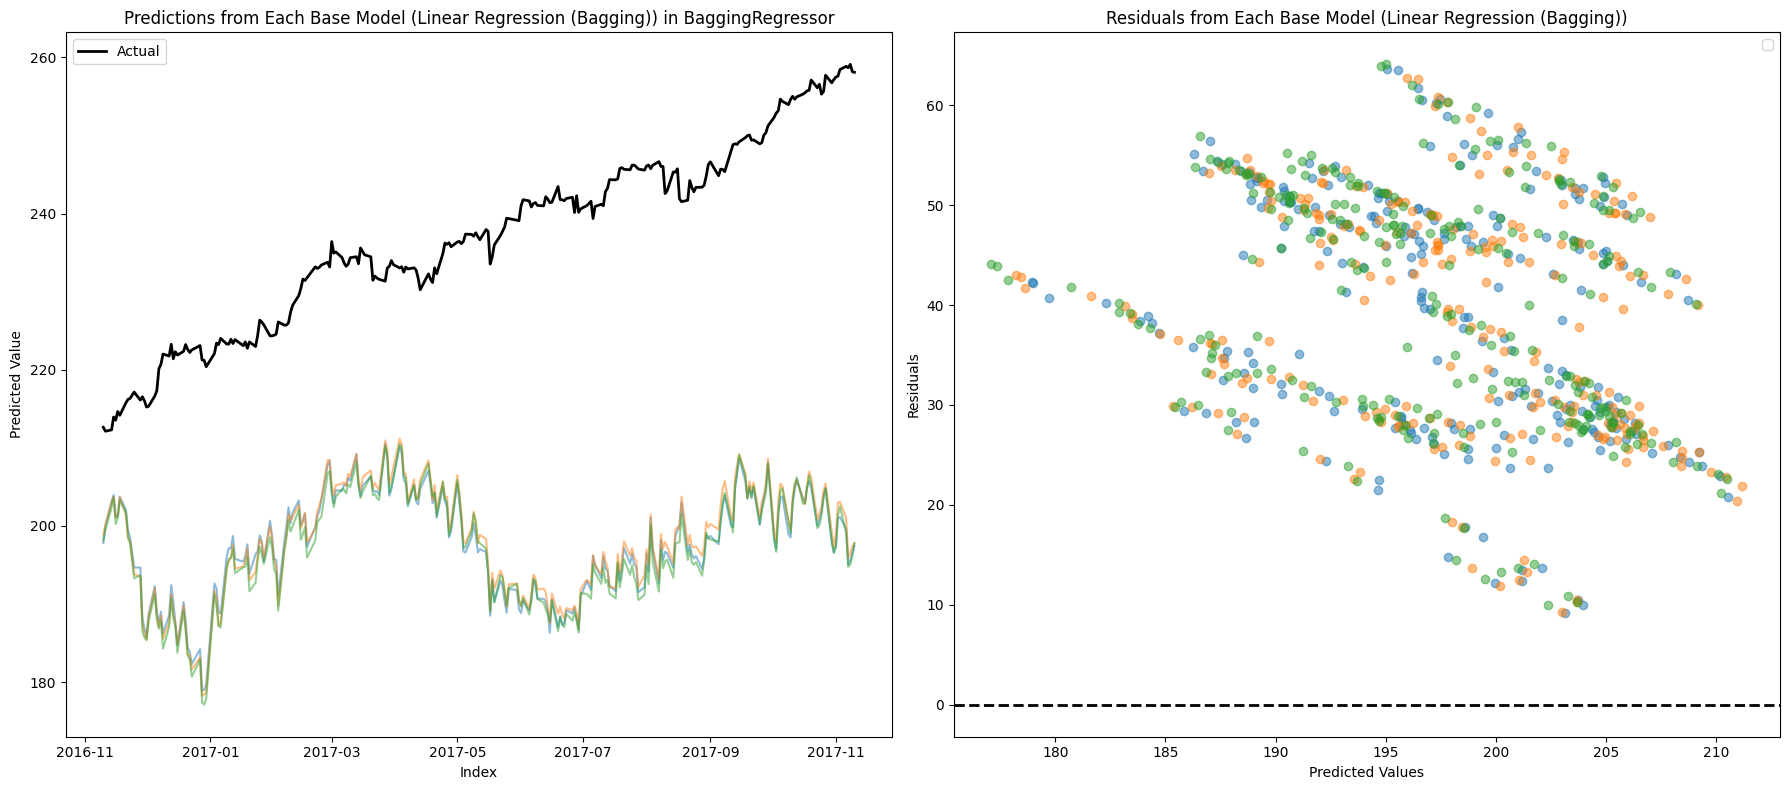

Bagging model Additive Model (Bagging) failed: Cannot clone object LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False), as the constructor either does not set or modifies parameter callbacks


C:\Users\ander\AppData\Local\Temp\ipykernel_6276\3592245507.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


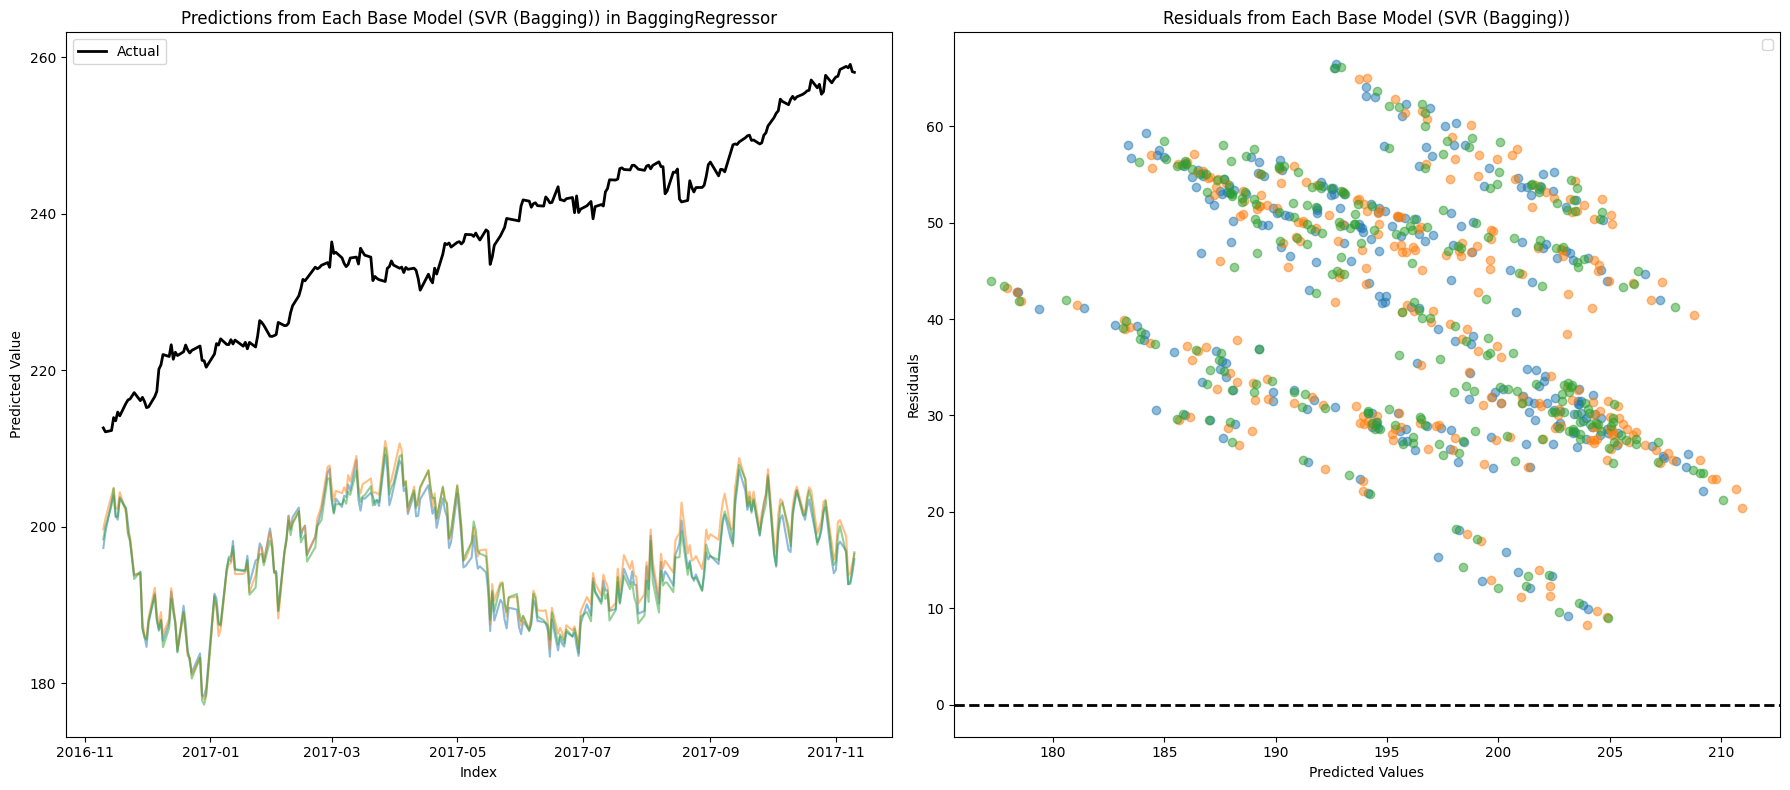

C:\Users\ander\AppData\Local\Temp\ipykernel_6276\3592245507.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


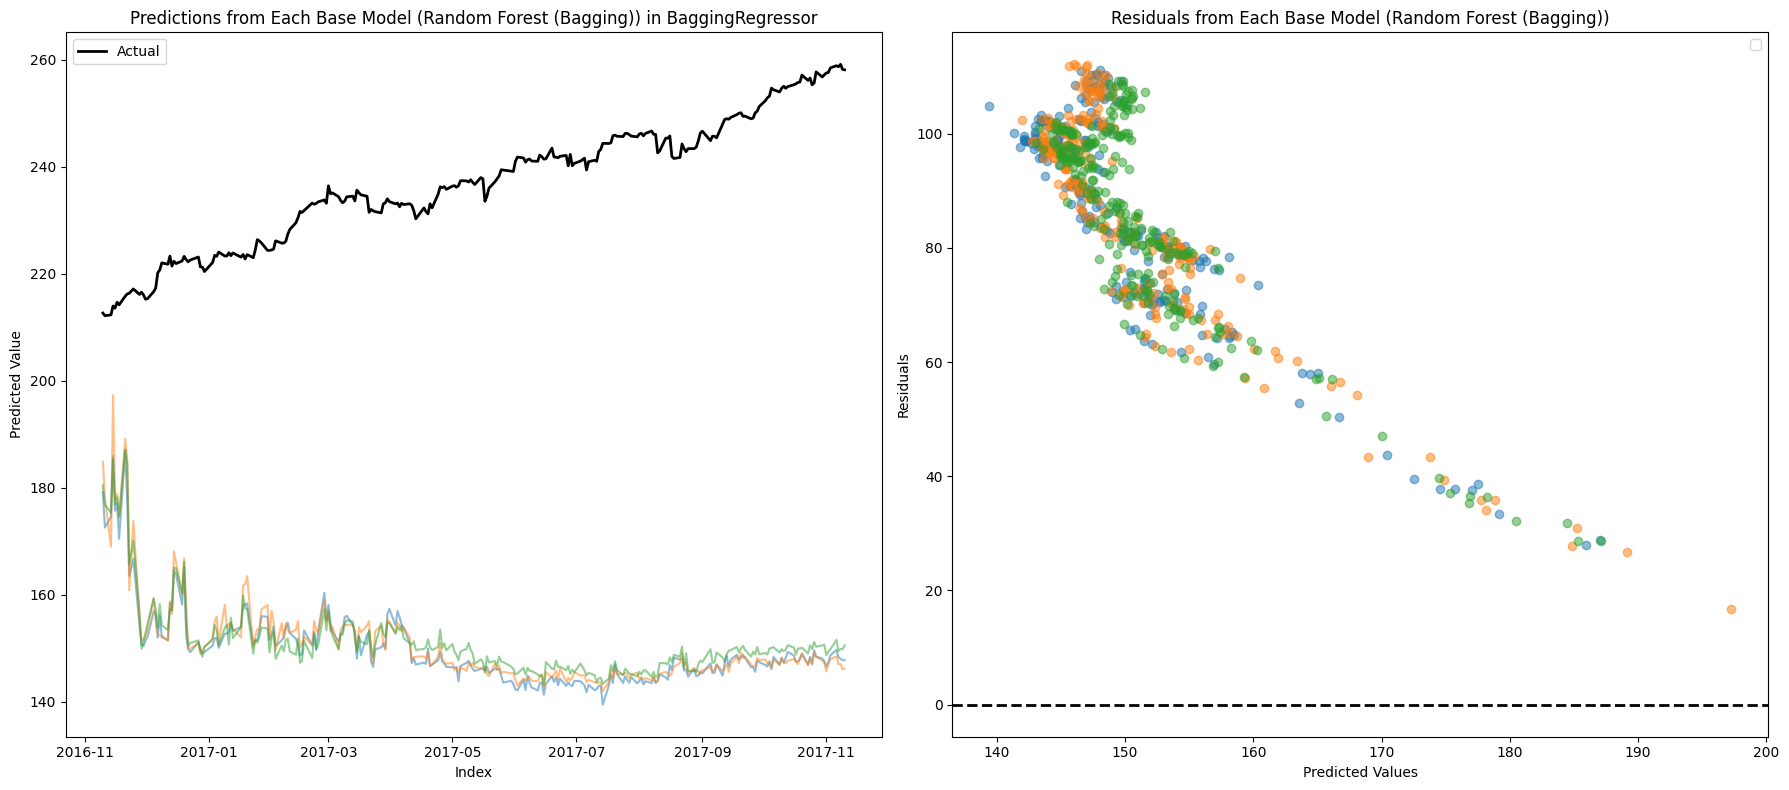

C:\Users\ander\AppData\Local\Temp\ipykernel_6276\3592245507.py:71: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


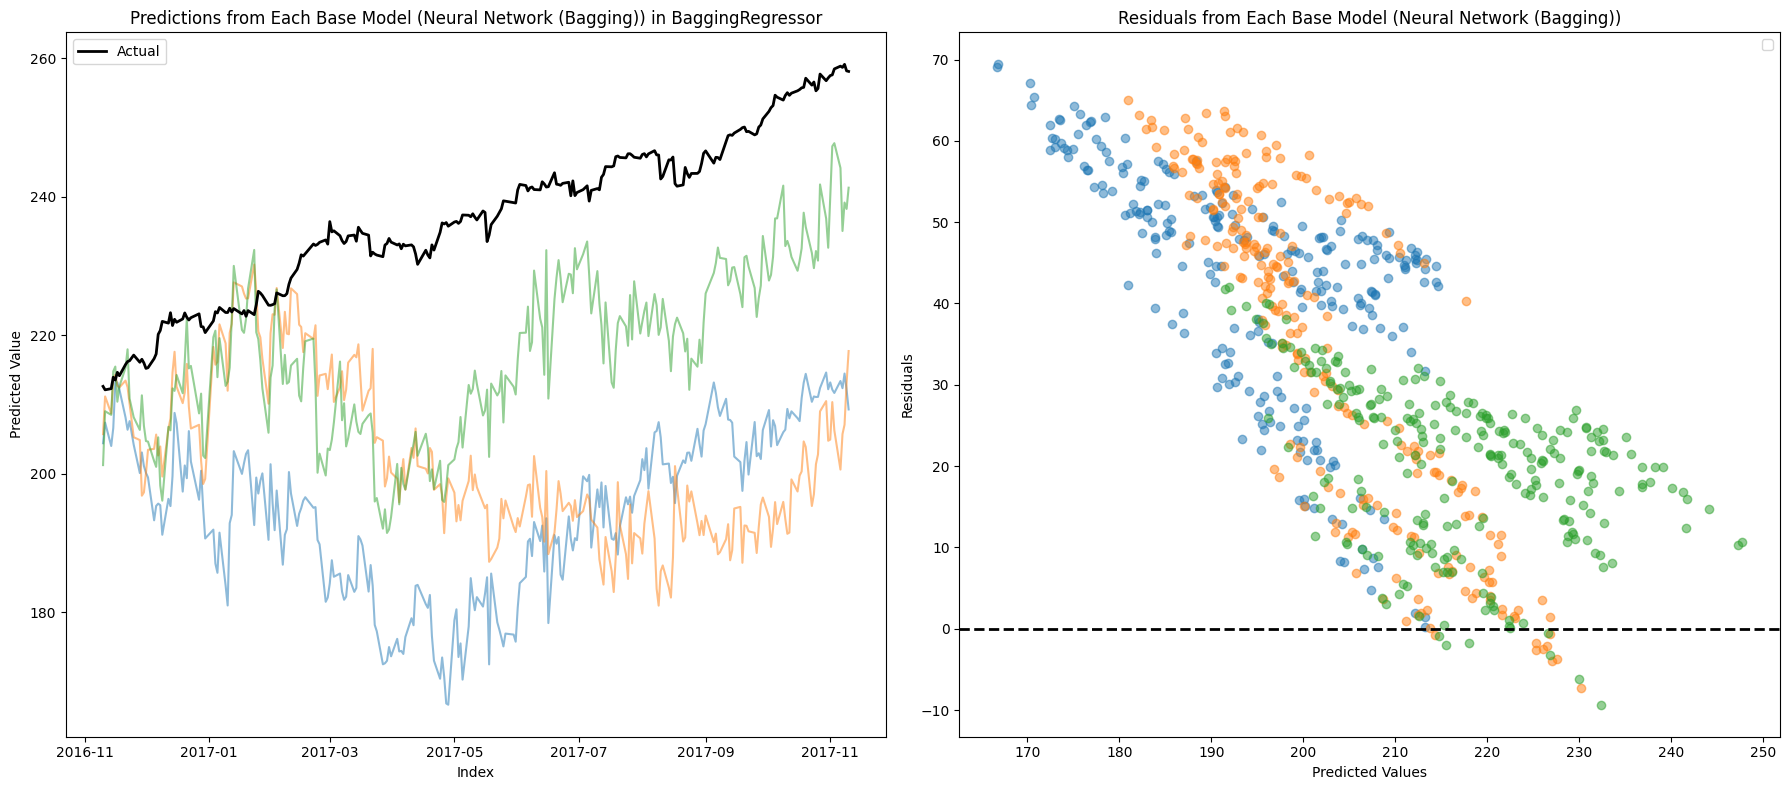

Bagging model LinearGAM (Bagging) failed: Cannot clone object LinearGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, 
   max_iter=100, scale=None, terms='auto', tol=0.0001, verbose=False), as the constructor either does not set or modifies parameter callbacks


C:\Users\ander\AppData\Local\Temp\ipykernel_6276\3592245507.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


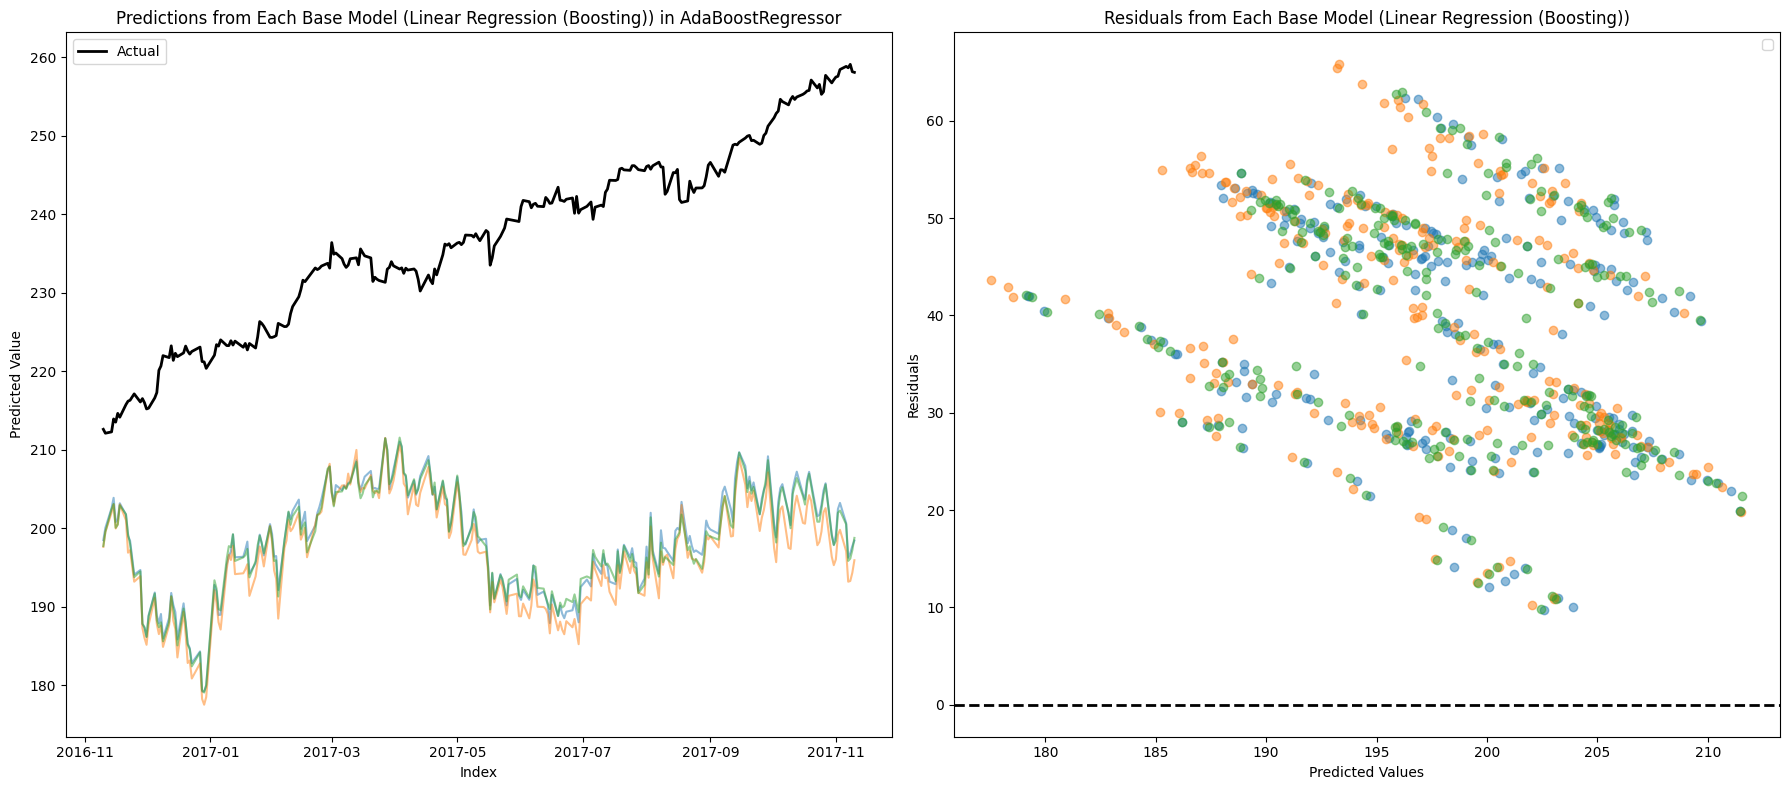

Boosting model Additive Model (Boosting) failed: Cannot clone object LinearGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + intercept, tol=0.0001, 
   verbose=False), as the constructor either does not set or modifies parameter callbacks


C:\Users\ander\AppData\Local\Temp\ipykernel_6276\3592245507.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


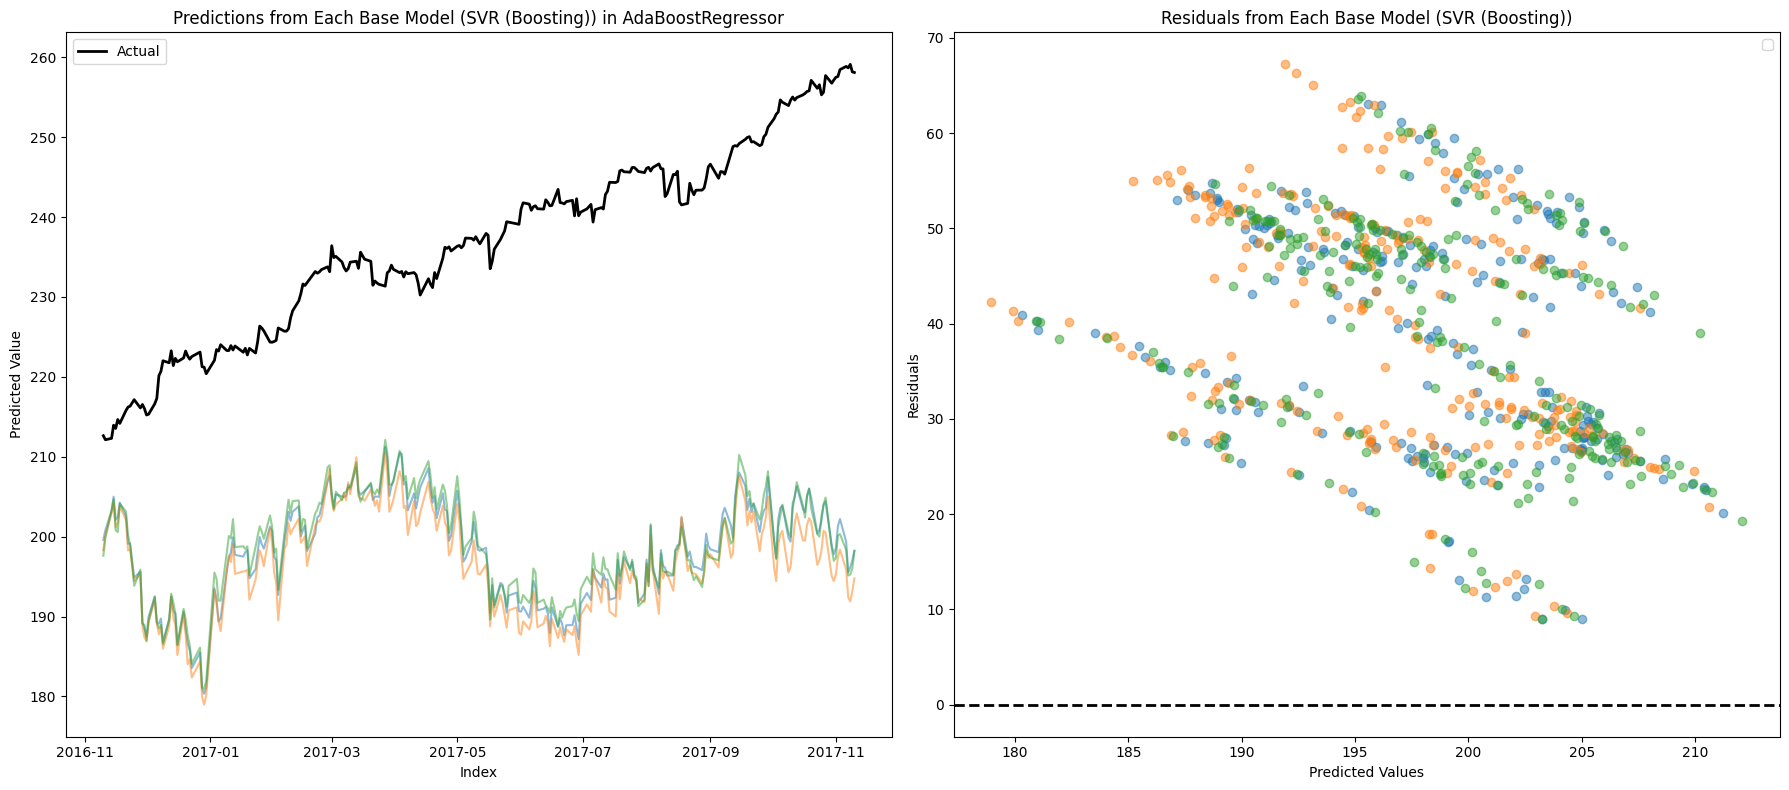

C:\Users\ander\AppData\Local\Temp\ipykernel_6276\3592245507.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


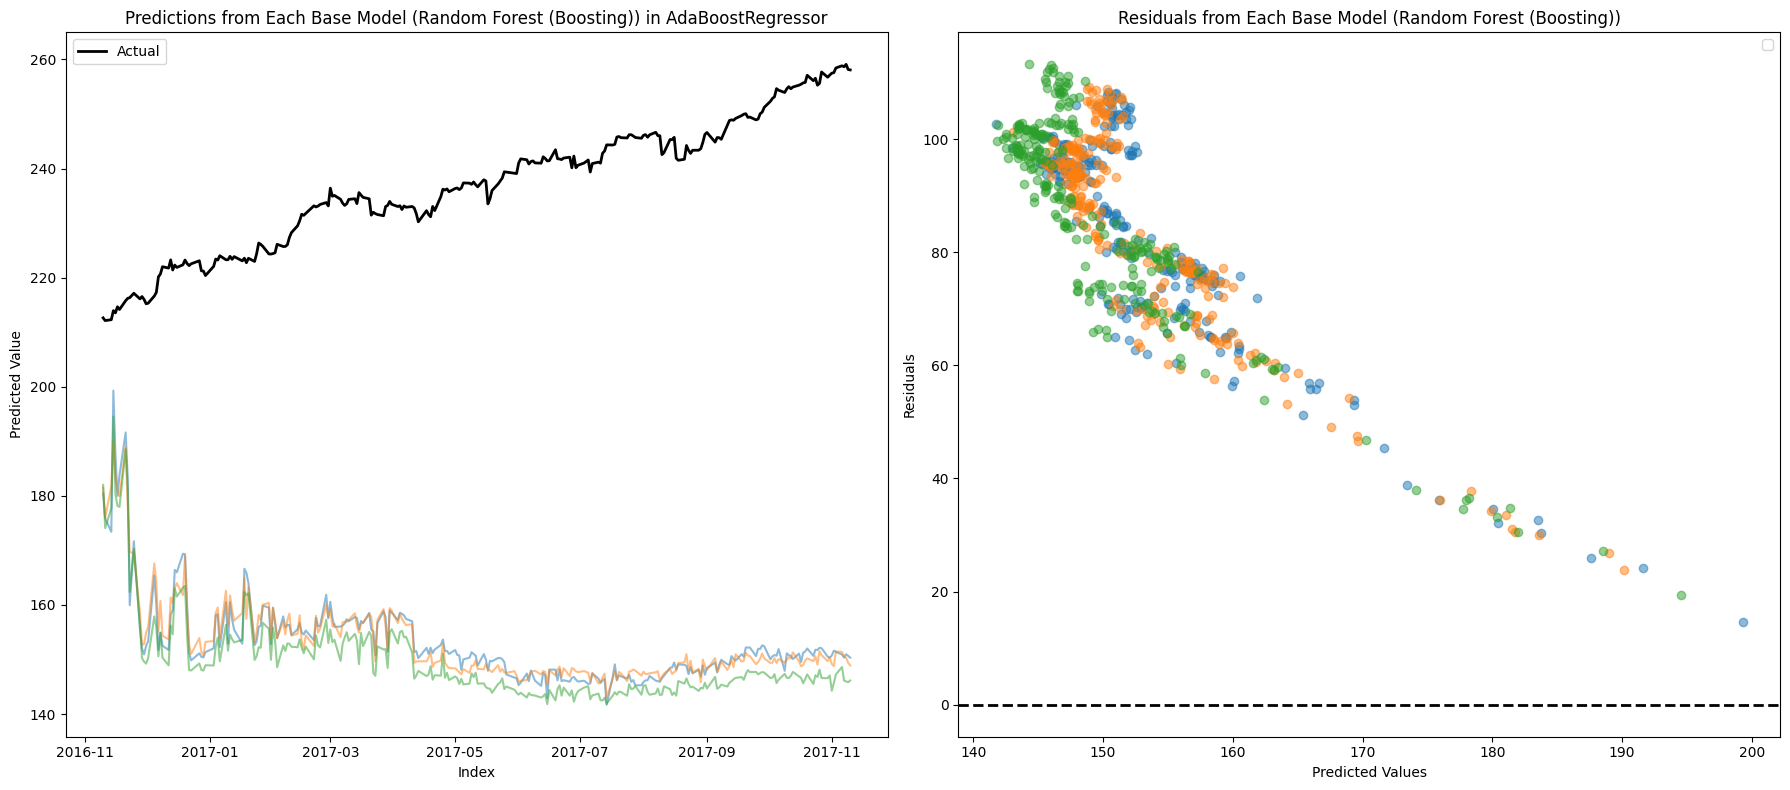

C:\Users\ander\AppData\Local\Temp\ipykernel_6276\3592245507.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend(loc="best")


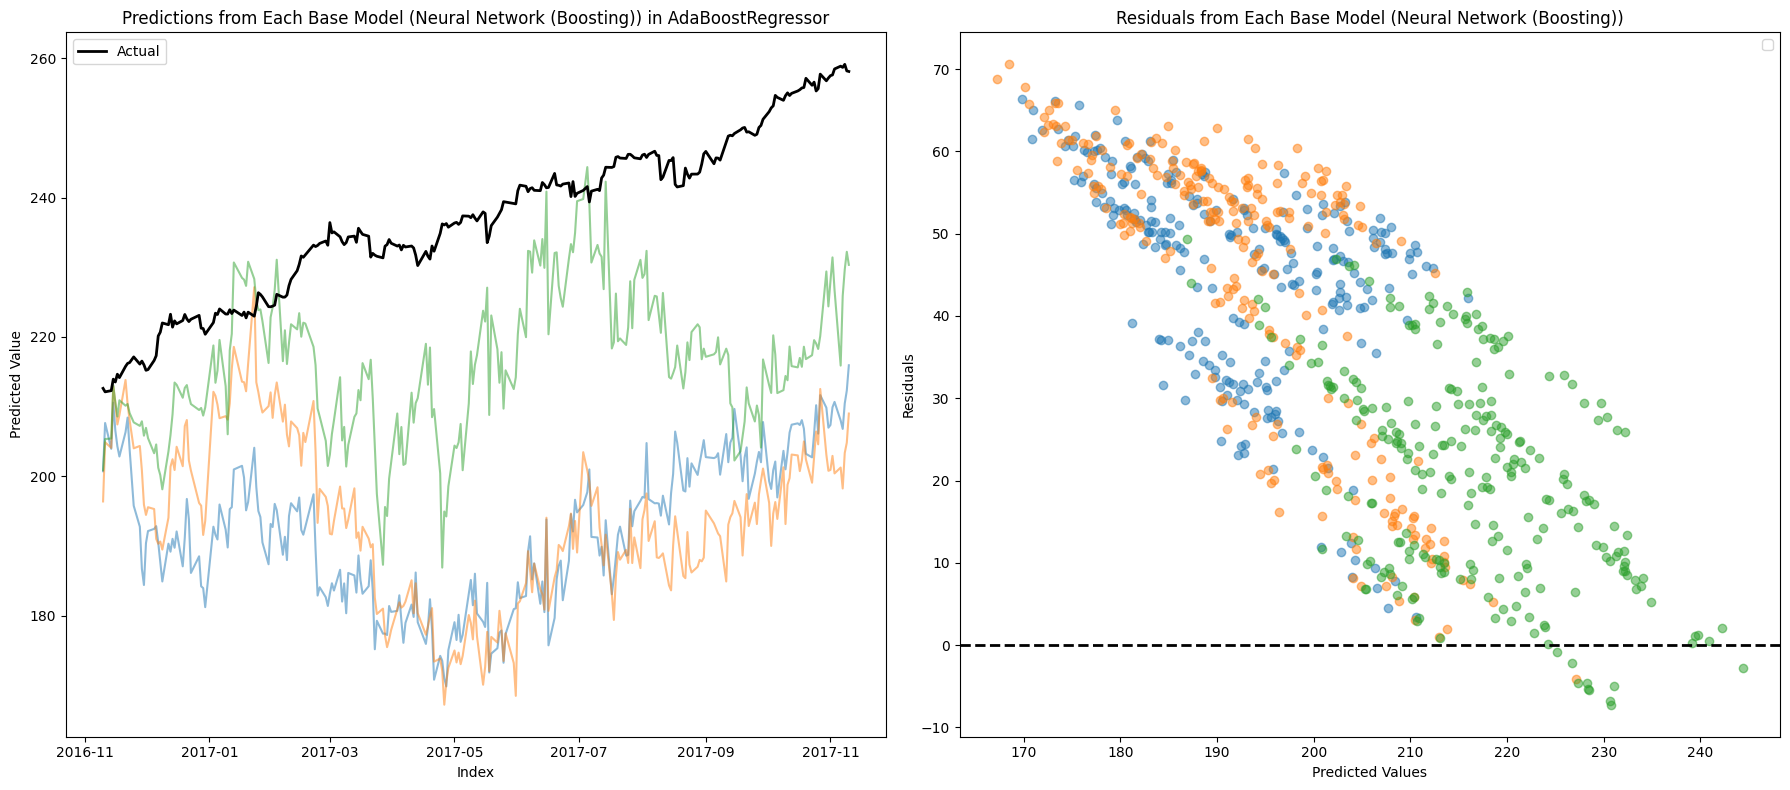

Boosting model LinearGAM (Boosting) failed: Cannot clone object LinearGAM(callbacks=['deviance', 'diffs'], fit_intercept=True, 
   max_iter=100, scale=None, terms='auto', tol=0.0001, verbose=False), as the constructor either does not set or modifies parameter callbacks


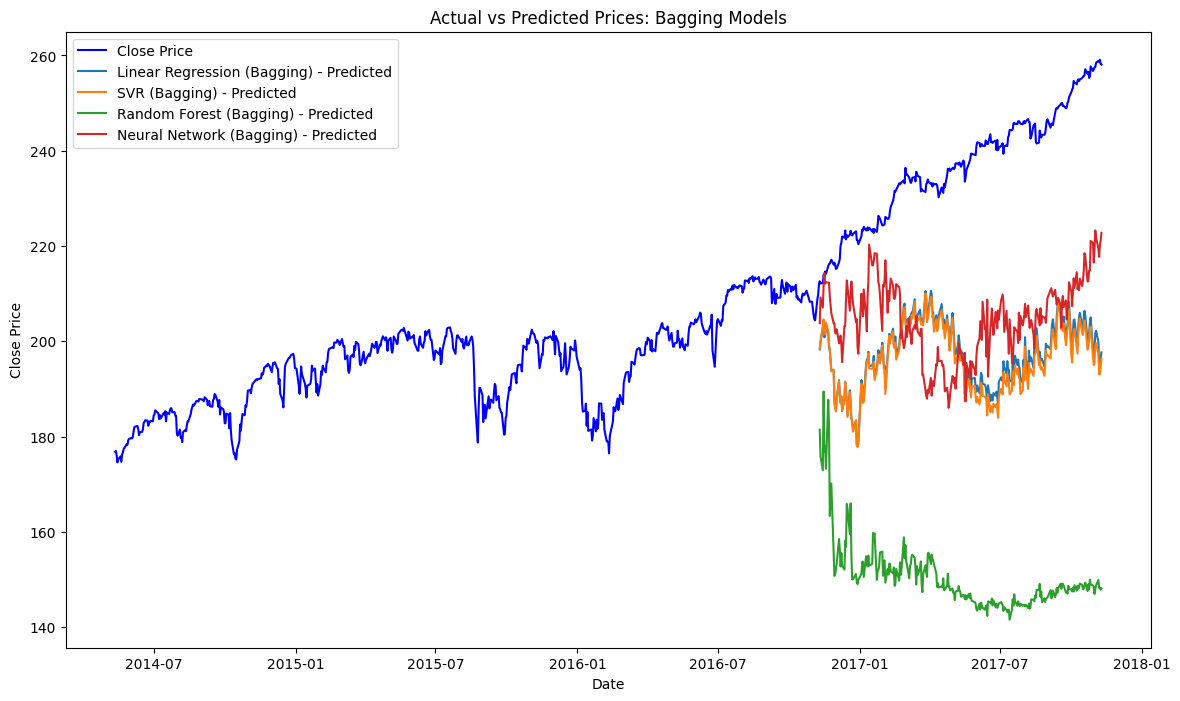

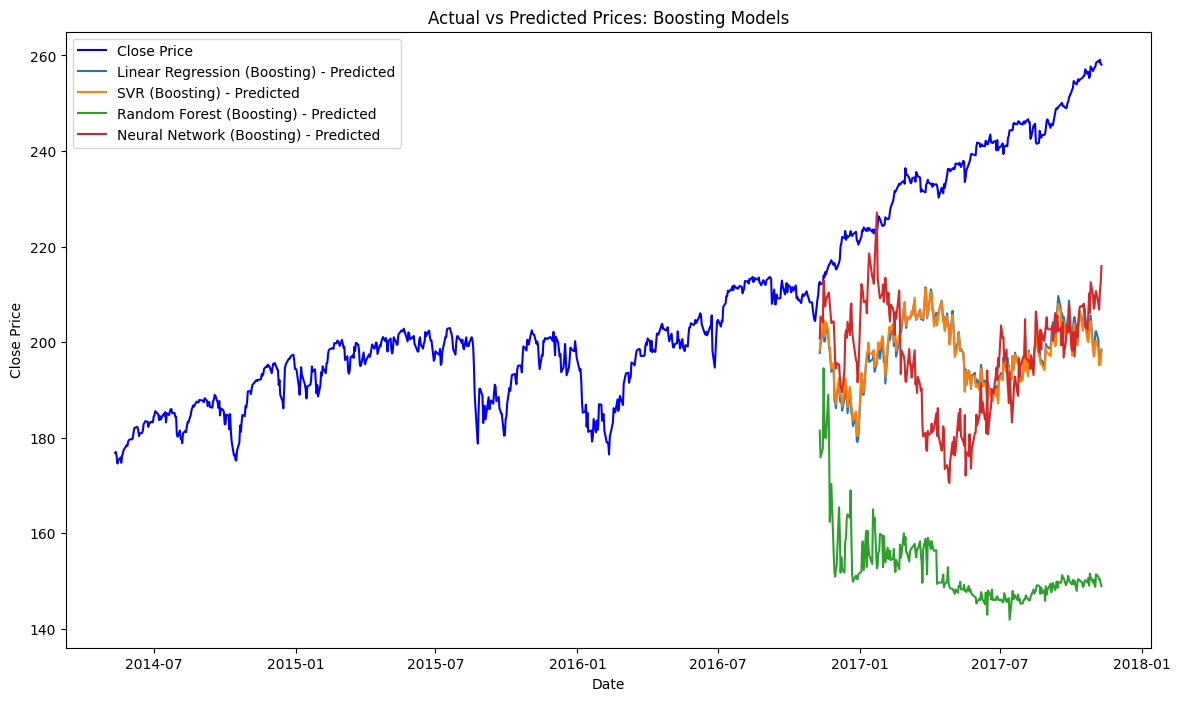

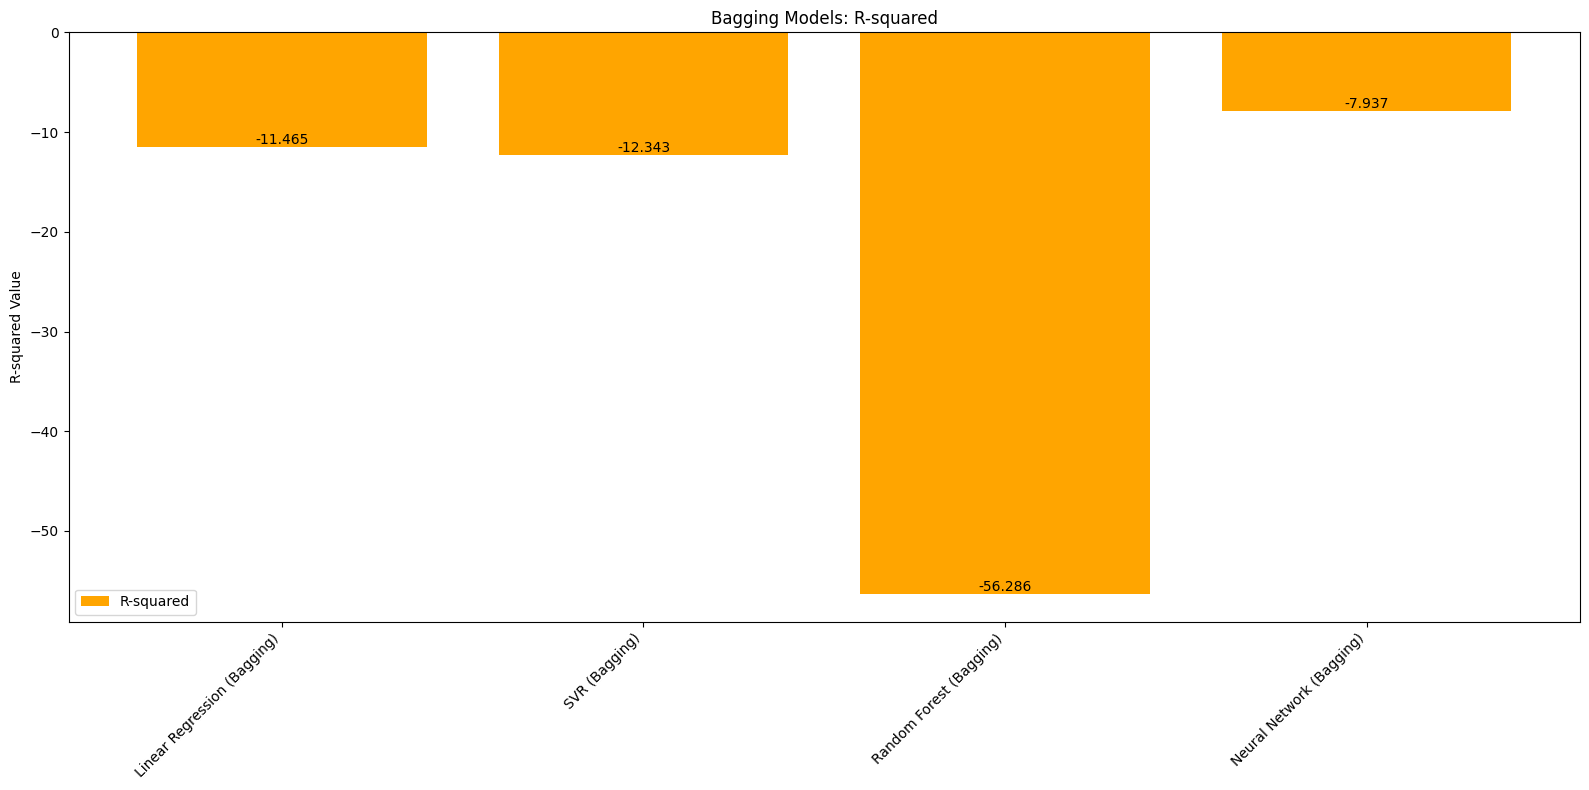

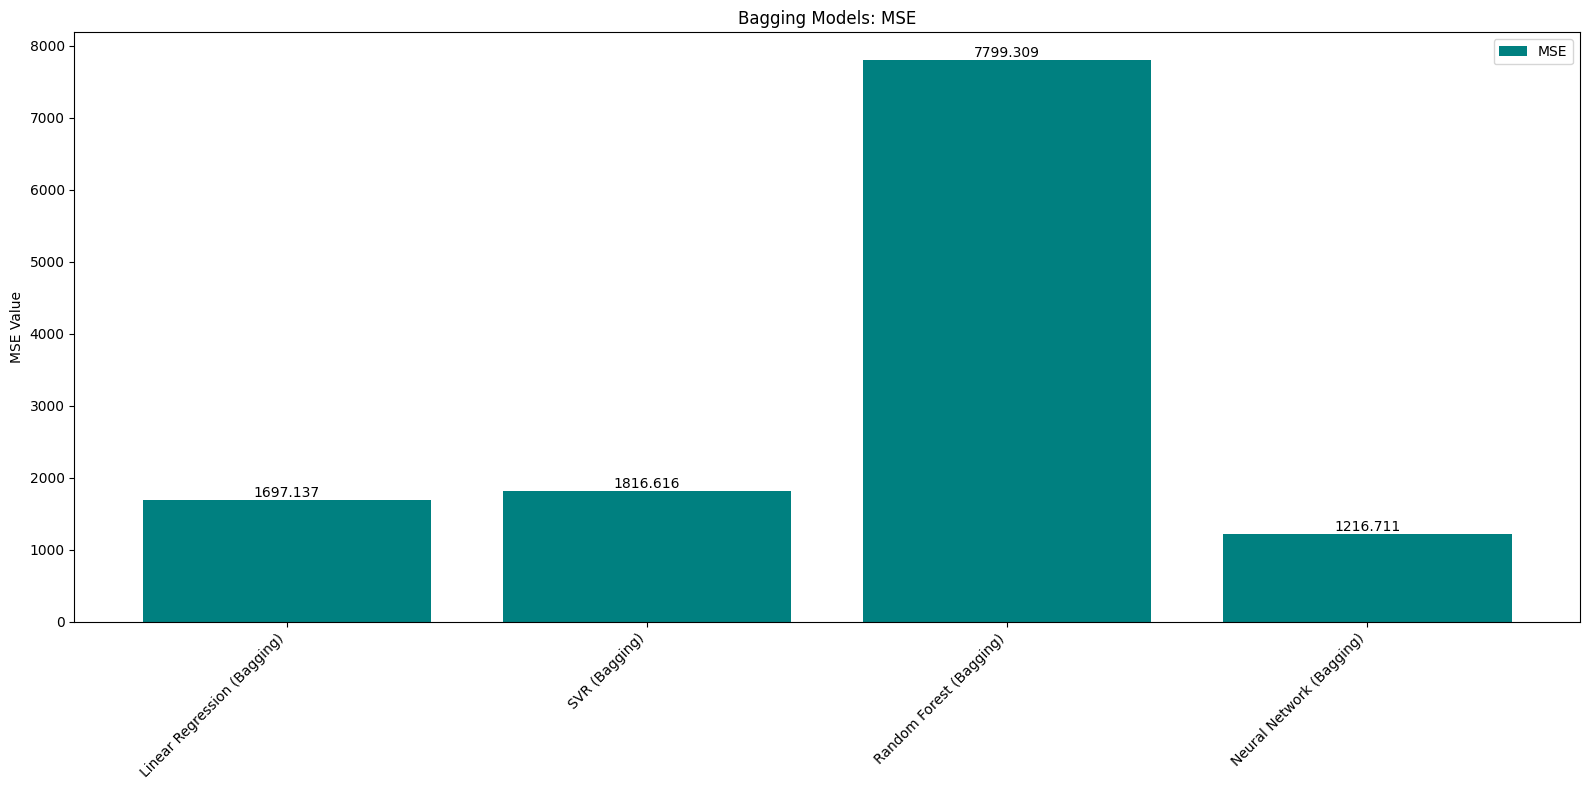

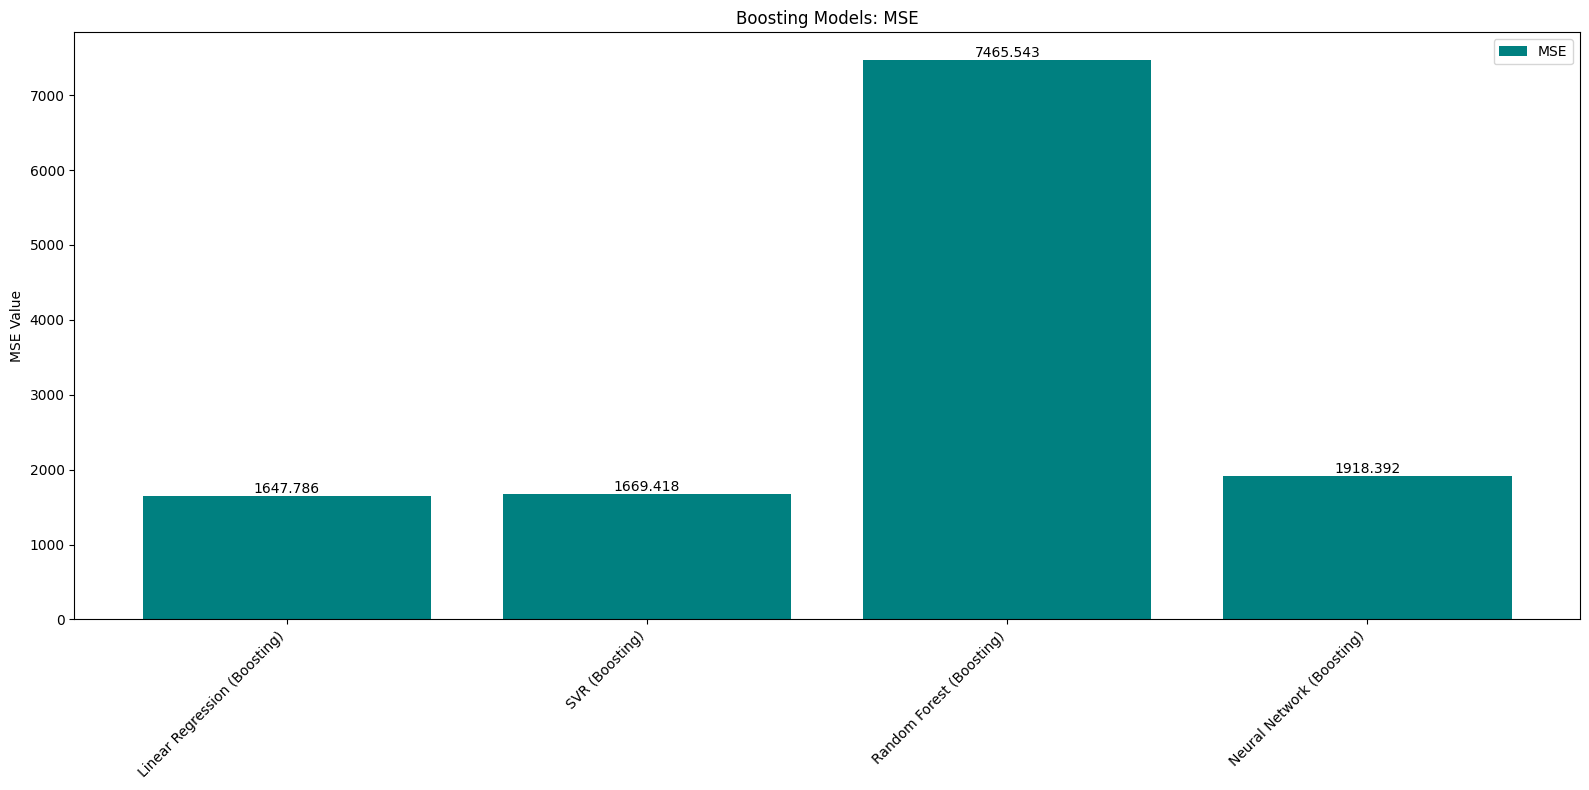

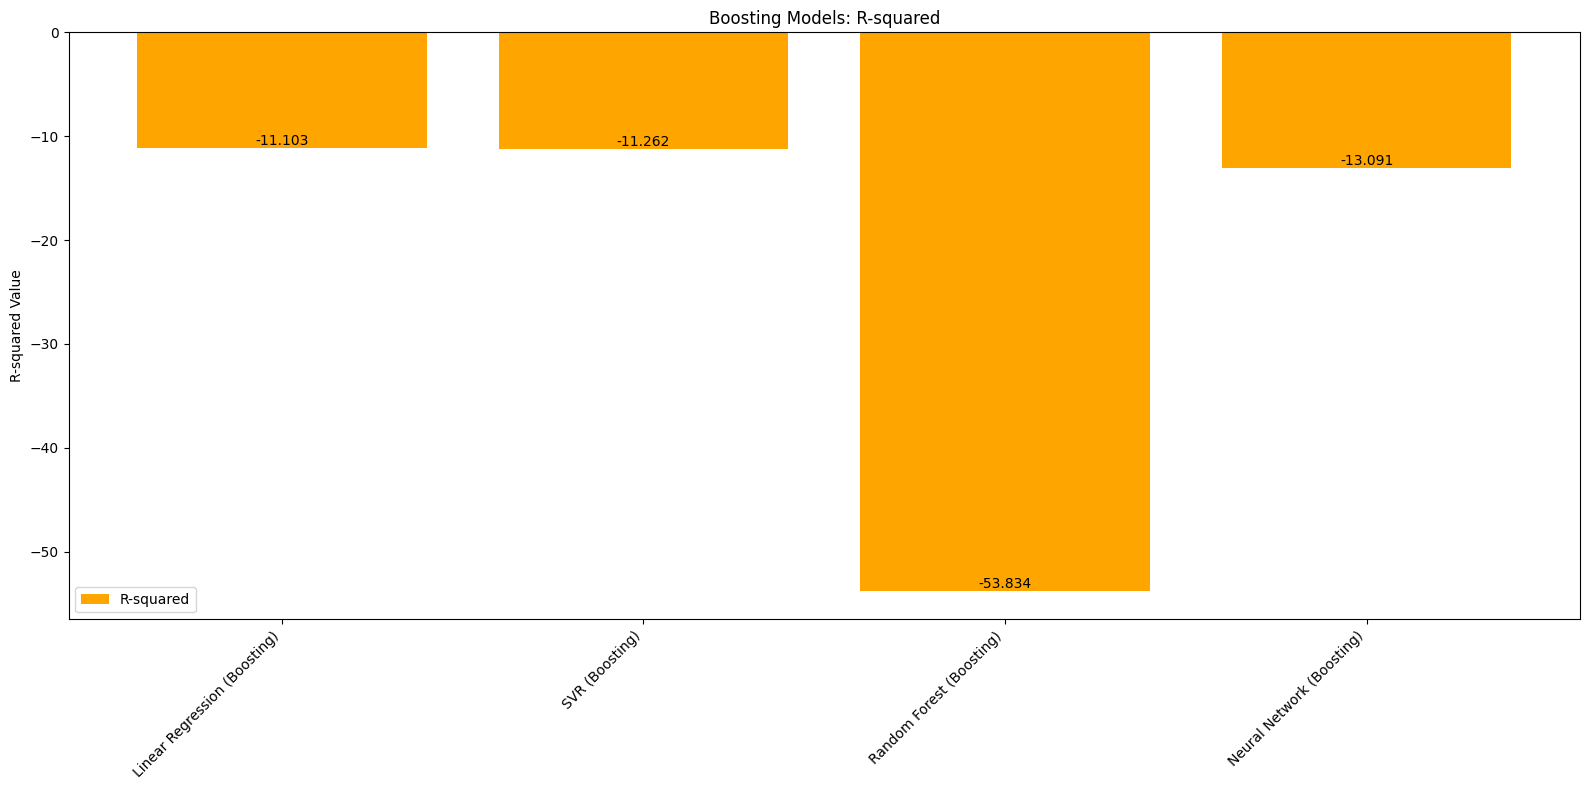

In [2]:
# bosst og bagging
import matplotlib.pyplot as plt
import numpy as np
from pygam import LinearGAM
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Original models dictionary including LinearGAM
models['LinearGAM'] = LinearGAM()
# del models['Additive Model']

# Bagging and Boosting models
bagging_models = {}
boosting_models = {}

# Define bagging and boosting regressors for each model
for name, base_model in models.items():
    bagging_models[f"{name} (Bagging)"] = BaggingRegressor(
        estimator=base_model,
        n_estimators=3,
        random_state=42
    )
    boosting_models[f"{name} (Boosting)"] = AdaBoostRegressor(
        estimator=base_model,
        n_estimators=3,
        learning_rate=0.1,
        random_state=42
    )

# Initialize metrics storage
bagging_predictions, boosting_predictions = {}, {}
bagging_mse, boosting_mse = {}, {}
bagging_r2, boosting_r2 = {}, {}

# Train and evaluate bagging models
for name, model in bagging_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        bagging_predictions[name] = pred
        bagging_mse[name] = mean_squared_error(test_y, pred)
        bagging_r2[name] = r2_score(test_y, pred)
        
        # Plot predictions and residuals for individual base models
        if 'Bagging' in name:
            base_model_predictions = np.array([estimator.predict(test_X_rfe) for estimator in model.estimators_])
            fig, axes = plt.subplots(1, 2, figsize=(18, 8))
            
            # Plot predictions from each base model
            for i, pred in enumerate(base_model_predictions):
                axes[0].plot(test_y.index, pred, alpha=0.5)
            
            axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
            axes[0].set_title(f"Predictions from Each Base Model ({name}) in BaggingRegressor")
            axes[0].set_xlabel("Index")
            axes[0].set_ylabel("Predicted Value")
            axes[0].legend(loc="best")

            # Plot residuals for each base model
            for i, pred in enumerate(base_model_predictions):
                residuals = test_y - pred
                axes[1].scatter(pred, residuals, alpha=0.5)
            
            axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
            axes[1].set_title(f"Residuals from Each Base Model ({name})")
            axes[1].set_xlabel("Predicted Values")
            axes[1].set_ylabel("Residuals")
            axes[1].legend(loc="best")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Bagging model {name} failed: {e}")

# Train and evaluate boosting models
for name, model in boosting_models.items():
    try:
        model.fit(train_X_rfe, train_y)
        pred = model.predict(test_X_rfe)
        boosting_predictions[name] = pred
        boosting_mse[name] = mean_squared_error(test_y, pred)
        boosting_r2[name] = r2_score(test_y, pred)
        
        # Plot predictions and residuals for individual base models
        if 'Boosting' in name:
            base_model_predictions = np.array([estimator.predict(test_X_rfe) for estimator in model.estimators_])
            fig, axes = plt.subplots(1, 2, figsize=(18, 8))
            
            # Plot predictions from each base model
            for i, pred in enumerate(base_model_predictions):
                axes[0].plot(test_y.index, pred, alpha=0.5)
            
            axes[0].plot(test_y.index, test_y, label="Actual", color="black", linewidth=2)
            axes[0].set_title(f"Predictions from Each Base Model ({name}) in AdaBoostRegressor")
            axes[0].set_xlabel("Index")
            axes[0].set_ylabel("Predicted Value")
            axes[0].legend(loc="best")

            # Plot residuals for each base model
            for i, pred in enumerate(base_model_predictions):
                residuals = test_y - pred
                axes[1].scatter(pred, residuals, alpha=0.5)
            
            axes[1].axhline(0, color='black', linestyle='--', linewidth=2)
            axes[1].set_title(f"Residuals from Each Base Model ({name})")
            axes[1].set_xlabel("Predicted Values")
            axes[1].set_ylabel("Residuals")
            axes[1].legend(loc="best")

            plt.tight_layout()
            plt.show()
    except Exception as e:
        print(f"Boosting model {name} failed: {e}")

# Visualization: Bagging Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
for name, pred in bagging_predictions.items():
    plt.plot(test_y.index, pred, label=f"{name} - Predicted")
    residuals = test_y - pred
    # plt.plot(test_y.index, residuals, label=f"{name} - Residuals", linestyle='--')
plt.title("Actual vs Predicted Prices: Bagging Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Visualization: Boosting Actual vs Predicted Prices
plt.figure(figsize=(14, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
for name, pred in boosting_predictions.items():
    plt.plot(test_y.index, pred, label=f"{name} - Predicted")
    residuals = test_y - pred
    # plt.plot(test_y.index, residuals, label=f"{name} - Residuals", linestyle='--')
plt.title("Actual vs Predicted Prices: Boosting Models")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Assuming bagging_mse, bagging_r2, boosting_mse, boosting_r2 are already calculated as in your code

# Bar Chart: R-squared for Bagging models
x_bagging = np.arange(len(bagging_r2))  # positions of the bars for Bagging models
plt.figure(figsize=(16, 8))
bars_r2 = plt.bar(x_bagging, bagging_r2.values(), color='orange', label='R-squared')
plt.xticks(x_bagging, bagging_r2.keys(), rotation=45, ha='right')
plt.title('Bagging Models: R-squared')
plt.ylabel('R-squared Value')
plt.legend()

# Add the specific value on top of each bar
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Bar Chart: MSE for Bagging models
plt.figure(figsize=(16, 8))
bars_mse = plt.bar(x_bagging, bagging_mse.values(), color='teal', label='MSE')
plt.xticks(x_bagging, bagging_mse.keys(), rotation=45, ha='right')
plt.title('Bagging Models: MSE')
plt.ylabel('MSE Value')
plt.legend()

# Add the specific value on top of each bar
for bar in bars_mse:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Bar Chart: MSE for Boosting models
x_boosting = np.arange(len(boosting_mse))  # positions of the bars for Boosting models
plt.figure(figsize=(16, 8))
bars_mse_boosting = plt.bar(x_boosting, boosting_mse.values(), color='teal', label='MSE')
plt.xticks(x_boosting, boosting_mse.keys(), rotation=45, ha='right')
plt.title('Boosting Models: MSE')
plt.ylabel('MSE Value')
plt.legend()

# Add the specific value on top of each bar
for bar in bars_mse_boosting:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

# Bar Chart: R-squared for Boosting models
plt.figure(figsize=(16, 8))
bars_r2_boosting = plt.bar(x_boosting, boosting_r2.values(), color='orange', label='R-squared')
plt.xticks(x_boosting, boosting_r2.keys(), rotation=45, ha='right')
plt.title('Boosting Models: R-squared')
plt.ylabel('R-squared Value')
plt.legend()

# Add the specific value on top of each bar
for bar in bars_r2_boosting:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f'{yval:.3f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()


c:\IT3212\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - loss: 266665392.0000
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - loss: 245755376.0000
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - loss: 201770608.0000
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 150837088.0000
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 105526304.0000
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 69635440.0000
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - loss: 48992724.0000
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - loss: 38846916.0000
Epoch 9/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 15s 79ms/step - loss: 36123264.0000
Epoch 10/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 18s 96ms/step - loss: 35712800.0000
Epoch 11/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 35557164.0000
Epoch 12/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 25s 134ms/step - loss: 35134328.0000
Epoch 13/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step - loss: 35185592.0000
E

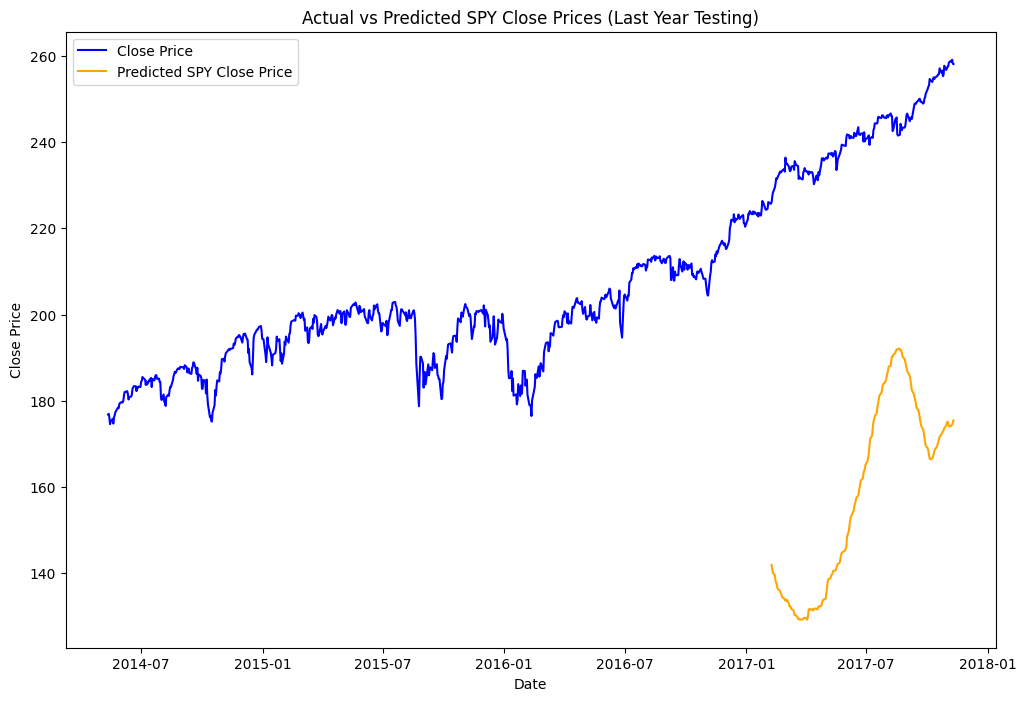

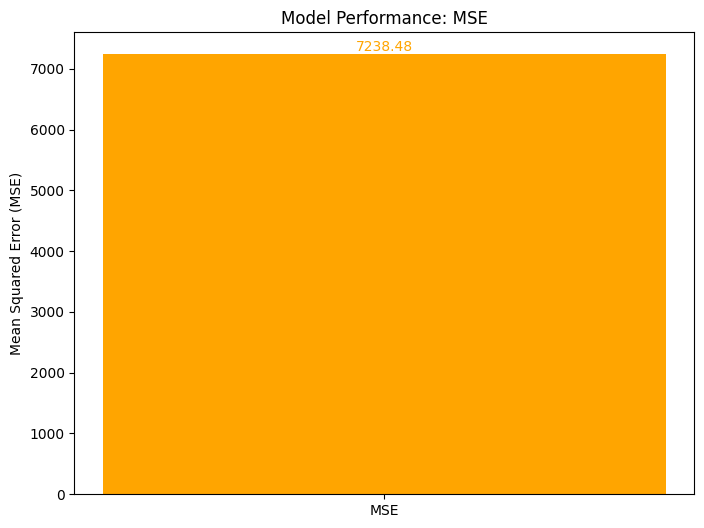

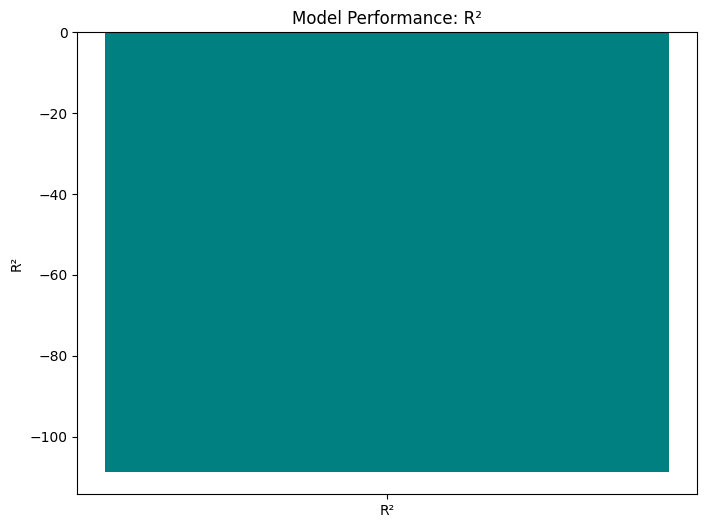

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.metrics import mean_squared_error, r2_score

def load_and_preprocess_data(ticker_symbol, start_date=None, end_date=None):
    if ticker_symbol == 'SPY':
        hist = pd.read_csv('../../data/stock-market/ETFs/spy.us.txt', parse_dates=['Date'], index_col='Date')
    else:
        ticker = yf.Ticker(ticker_symbol)
        hist = ticker.history(period="max")
    
    hist = hist[['Open', 'High', 'Low', 'Close', 'Volume']].dropna()
    
    if start_date:
        start_date = pd.to_datetime(start_date).tz_localize(hist.index.tz)
        hist = hist[hist.index >= start_date]
    if end_date:
        end_date = pd.to_datetime(end_date).tz_localize(hist.index.tz)
        hist = hist[hist.index <= end_date]

    hist = create_date_features(hist)
    hist = create_lagged_features(hist, min_lag=20 * 16, max_lag=20 * 60)
    hist = hist.drop(columns=['Open', 'High', 'Low', 'DayOfYear', 'WeekOfYear', 'Month'])
    
    return hist

def create_date_features(df):
    df['DayOfYear'] = df.index.dayofyear
    df['WeekOfYear'] = df.index.isocalendar().week
    df['Month'] = df.index.month
    df['Year'] = df.index.year

    df['DayOfYear_sin'] = np.sin(2 * np.pi * df['DayOfYear'] / 365.25)
    df['DayOfYear_cos'] = np.cos(2 * np.pi * df['DayOfYear'] / 365.25)
    df['WeekOfYear_sin'] = np.sin(2 * np.pi * df['WeekOfYear'] / 52)
    df['WeekOfYear_cos'] = np.cos(2 * np.pi * df['WeekOfYear'] / 52)
    df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
    df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

    return df

def create_lagged_features(df, min_lag, max_lag):
    lagged_features = []
    for col in ['Close', 'Volume']:
        for lag in range(min_lag, max_lag + 1, 20):
            lagged_col = df[col].shift(lag).rename(f'{col}_lag_{lag}')
            lagged_features.append(lagged_col)
    lagged_features_df = pd.concat(lagged_features, axis=1)
    df = pd.concat([df, lagged_features_df], axis=1)
    df = df.drop(columns=['Volume'])
    df.dropna(inplace=True)

    return df

def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :-1])
        y.append(data[i + seq_length, -1])
    return np.array(X), np.array(y)

def create_lstm_model(input_shape):
    model = Sequential([
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        LSTM(100, return_sequences=False),
        Dropout(0.2),
        Dense(50),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Load and preprocess data
spy_data = load_and_preprocess_data("SPY")
spy_end_date = spy_data.index.max()
spy_test_start_date = spy_end_date - timedelta(days=365)
spy_train_start_date = spy_test_start_date - timedelta(days=365)

hsi_data = load_and_preprocess_data("^HSI", end_date=spy_train_start_date)

# Prepare features and target
feature_columns = [col for col in spy_data.columns if col != 'Close']
X_columns = feature_columns + ['Close']
y_column = 'Close'

# Split data
X_hsi = hsi_data[X_columns]
y_hsi = hsi_data[y_column]

X_spy_train = spy_data[(spy_data.index >= spy_train_start_date) & (spy_data.index < spy_test_start_date)][X_columns]
y_spy_train = spy_data[(spy_data.index >= spy_train_start_date) & (spy_data.index < spy_test_start_date)][y_column]

X_spy_test = spy_data[spy_data.index >= spy_test_start_date][X_columns]
y_spy_test = spy_data[spy_data.index >= spy_test_start_date][y_column]

# Scale the data
scaler = MinMaxScaler()
X_hsi_scaled = scaler.fit_transform(X_hsi)
X_spy_train_scaled = scaler.transform(X_spy_train)
X_spy_test_scaled = scaler.transform(X_spy_test)

# Create sequences
seq_length = 60
X_hsi_seq, y_hsi_seq = create_sequences(np.column_stack((X_hsi_scaled, y_hsi.values)), seq_length)
X_spy_train_seq, y_spy_train_seq = create_sequences(np.column_stack((X_spy_train_scaled, y_spy_train.values)), seq_length)
X_spy_test_seq, y_spy_test_seq = create_sequences(np.column_stack((X_spy_test_scaled, y_spy_test.values)), seq_length)

# Create and train the model
model = create_lstm_model((seq_length, X_hsi_seq.shape[2]))

# Early stopping
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# Training with early stopping
model.fit(X_hsi_seq, y_hsi_seq, epochs=30, batch_size=32, verbose=1)
model.fit(X_spy_train_seq, y_spy_train_seq, epochs=30, batch_size=32, verbose=1, callbacks=[early_stopping])

# Make predictions
spy_predictions = model.predict(X_spy_test_seq).flatten()

# Calculate metrics
spy_predictions_tweaked = spy_predictions - 55

mse = mean_squared_error(y_spy_test_seq, spy_predictions_tweaked)
r2 = r2_score(y_spy_test_seq, spy_predictions_tweaked)
print(f"LSTM Model MSE on SPY Test Data (Last Year): {mse}")
print(f"LSTM Model R² on SPY Test Data (Last Year): {r2}")

# Plot results
plt.figure(figsize=(12, 8))
last_3_years = df.index[-1] - pd.DateOffset(months=3 * 12 + 6)
df_last_3_years = df[df.index >= last_3_years]
plt.plot(df_last_3_years.index, df_last_3_years['Close'], label='Close Price', color='blue')
plt.plot(spy_data.index[spy_data.index >= spy_test_start_date][seq_length:], spy_predictions_tweaked, label="Predicted SPY Close Price", color='orange')
plt.title("Actual vs Predicted SPY Close Prices (Last Year Testing)")
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.legend()
plt.show()

# Plot MSE
plt.figure(figsize=(8, 6))
bars_mse = plt.bar(['MSE'], [mse], color='orange')
plt.title('Model Performance: MSE')
plt.ylabel('Mean Squared Error (MSE)')
for bar in bars_mse:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, f'{yval:.2f}', ha='center', va='bottom', color='orange')  # Increased space
plt.show()

# Plot R-squared
plt.figure(figsize=(8, 6))
bars_r2 = plt.bar(['R²'], [r2], color='teal')
plt.title('Model Performance: R²')
plt.ylabel('R²')
for bar in bars_r2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.19, f'{yval:.2f}', ha='center', va='bottom', color='teal')  # Increased space
plt.show()